# Python for Finance - part 7

#### 금융분석과 관련된 기본적인 내용을 정리하였습니다. 파이썬을 활용한 금융분석 (이브 힐피시 지음)을 참고하였습니다.

## Chapter 11 통계 분석
#### 정규성 검정 : 평균-분산 포트폴리오 이론이나 자본 자산 가격결정모형(CAPM)과 같은 많은 중요한 금융 모형들은 증권수익률이 정규분포라는 가정을 하고 있음
#### 포트폴리오 이론
#### 주성분 분석 : 주식 투자 전략을 집행하거나 이자율 움직임을 설명하는 주요 성분을 분석하는 도구 / 연관된 시계열 성분들로부터 소수의 선형-독립적인 성분을 이끌어 내어 분석의 복잡도를 낮춤
#### 베이즈 회귀 : 통계학에 확률의 주관적 척도와 이를 갱신한다는 개념을 도입 / 회귀 인수 값을 하나의 추정치로 보는 대신 이에 대한 통계적인 분포를 고려

### 11.1 정규성 검정
#### 포트폴리오 이론 : 주식 수익률이 정규분포를 이루면 최적 포트폴리오를 선택하는 문제는 각 주식의 평균 수익률과 수익률의 분산, 주식 사이의 공분산 만을 고려하는 투자 결정 문제로 귀착
#### 자본 자산 가격 결정 모형 : 주식 수익률이 정규분포를 이루면 개별 주식의 가격과 전체 시장 지수의 관계는 베타라고 불리는 개별 주식과 시장 지수의 공통 움직임을 설명하는 측도로 표현 가능
#### 효율적 시장 가설 : 효율적 시장은 얻을 수 있는 모든 정보가 가격에 반영된 시장, 효율적 시장 가설이 맞는다면 주식 가격은 무작위로 움직이게 되며 수익률은 정규분포를 따름
#### 옵션 가격결정 모형 : 블랙-숄즈-머튼 옵션 가격결정 공식은 주식의 우밎ㄱ임에 대해 정규분포 수익률을 발생시키는 기하 브라운 운동 모형을 사용 

#### 11.1.1 벤치마크 자료 분석
#### 로그 정규분포 수익률 : 시간 사이의 로그 수익률은 정규분포
#### 로그 정규분포 값 : 임의의 시간에서 수익률은 로그 정규분포를 따름

In [2]:
import numpy as np
np.random.seed(1000)
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
def gen_paths(S0, r, sigma, T, M, I):
    """ 기하 브라운 운동 모형에 대한 몬테카를로 경로를 생성"""
    
    dt = float(T) / M
    paths = np.zeros(((M+1), I), np.float64)
    paths[0] = S0
    for t in range(1, M+1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()
        paths[t] = paths[t-1] * np.exp((r-0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rand)
        
    return paths

S0 = 100.
r = .05
sigma = .2
T = 1.
M = 50
I = 250000
paths = gen_paths(S0, r, sigma, T, M, I)

Text(0, 0.5, 'index level')

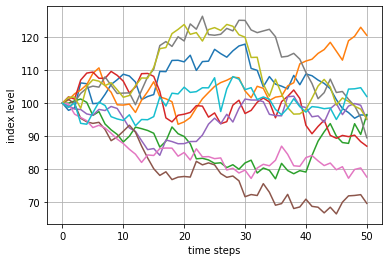

In [6]:
plt.plot(paths[:, :10])
plt.grid(True)
plt.xlabel('time steps')
plt.ylabel('index level')

In [7]:
log_returns = np.log(paths[1:] / paths[0:-1])

In [9]:
paths[:, 0].round(4)

array([100.    ,  97.821 ,  98.5573, 106.1546, 105.899 ,  99.8363,
       100.0145, 102.6589, 105.6643, 107.1107, 108.7943, 108.2449,
       106.4105, 101.0575, 102.0197, 102.6052, 109.6419, 109.5725,
       112.9766, 113.0225, 112.5476, 114.5585, 109.942 , 112.6271,
       112.7502, 116.3453, 115.0443, 113.9586, 115.8831, 117.3705,
       117.9185, 110.5539, 109.9687, 104.9957, 108.0679, 105.7822,
       105.1585, 104.3304, 108.4387, 105.5963, 108.866 , 108.3284,
       107.0077, 106.0034, 104.3964, 101.0637,  98.3776,  97.135 ,
        95.4254,  96.4271,  96.3386])

In [10]:
log_returns[:, 0].round(4)

array([-0.022 ,  0.0075,  0.0743, -0.0024, -0.059 ,  0.0018,  0.0261,
        0.0289,  0.0136,  0.0156, -0.0051, -0.0171, -0.0516,  0.0095,
        0.0057,  0.0663, -0.0006,  0.0306,  0.0004, -0.0042,  0.0177,
       -0.0411,  0.0241,  0.0011,  0.0314, -0.0112, -0.0095,  0.0167,
        0.0128,  0.0047, -0.0645, -0.0053, -0.0463,  0.0288, -0.0214,
       -0.0059, -0.0079,  0.0386, -0.0266,  0.0305, -0.0049, -0.0123,
       -0.0094, -0.0153, -0.0324, -0.0269, -0.0127, -0.0178,  0.0104,
       -0.0009])

In [12]:
def print_statistics(array):
    """
    필요한 통계치를 출력
    """
    stat1 = scs.describe(array)
    
    print("%14s %15s" % ('statistic', 'value'))
    print(45*'-')
    print("%14s %15.5f" % ('size', stat1[0]))
    print("%14s %15.5f" % ('min', stat1[1][0]))
    print("%14s %15.5f" % ('max', stat1[1][1]))
    print("%14s %15.5f" % ('mean', stat1[2]))
    print("%14s %15.5f" % ('std', np.sqrt(stat1[3])))
    print("%14s %15.5f" % ('skew', stat1[4]))
    print("%14s %15.5f" % ('kurtosis', stat1[5]))
    
    
print_statistics(log_returns.flatten())

     statistic           value
---------------------------------------------
          size  12500000.00000
           min        -0.15664
           max         0.15371
          mean         0.00060
           std         0.02828
          skew         0.00055
      kurtosis         0.00085


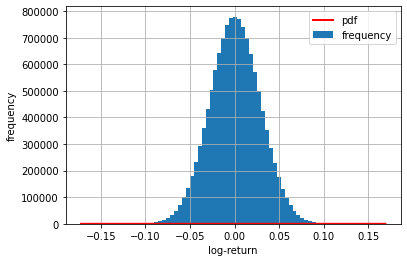

In [14]:
plt.hist(log_returns.flatten(), bins=70, label='frequency')
plt.grid(True)
plt.xlabel('log-return')
plt.ylabel('frequency')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, loc=r/M, scale=sigma/np.sqrt(M)), 'r', lw=2., label='pdf')
plt.legend()

Text(0, 0.5, 'sample quantile')

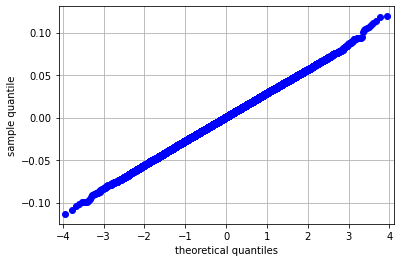

In [17]:
sm.qqplot(log_returns.flatten()[::500])
plt.grid(True)
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantile')

#### 왜도 검정 : 샘플 자료의 왜도가 정규분포와 일치하는지 검정
#### 첨도 검정 : 샘플 자료의 첨도가 정규분포와 일치하는지 검정
#### 정규성 검정

In [20]:
def normality_tests(arr):
    """ 주어진 데이터가 정규분포인지 검정"""
    
    print("Skew of data set %14.3f" % scs.skew(arr))
    print("Skew test p-value %14.3f" % scs.skewtest(arr)[1])
    print("Kurt of data set %14.3f" % scs.kurtosis(arr))
    print("Kurt test p-value %14.3f" % scs.kurtosistest(arr)[1])
    print("Norm test p-value  %14.3f" % scs.normaltest(arr)[1])
    
    
normality_tests(log_returns.flatten())

Skew of data set          0.001
Skew test p-value          0.430
Kurt of data set          0.001
Kurt test p-value          0.541
Norm test p-value           0.607


In [21]:
print_statistics(paths[-1])

     statistic           value
---------------------------------------------
          size    250000.00000
           min        42.74870
           max       233.58435
          mean       105.12645
           std        21.23174
          skew         0.61116
      kurtosis         0.65182


In [22]:
print_statistics(np.log(paths[-1]))

     statistic           value
---------------------------------------------
          size    250000.00000
           min         3.75534
           max         5.45354
          mean         4.63517
           std         0.19998
          skew        -0.00092
      kurtosis        -0.00327


In [23]:
normality_tests(np.log(paths[-1]))

Skew of data set         -0.001
Skew test p-value          0.851
Kurt of data set         -0.003
Kurt test p-value          0.744
Norm test p-value           0.931


#### 11.1.2 현실 자료 분석

In [24]:
from pandas_datareader import data as web
import pandas as pd
import yfinance as yf
yf.pdr_override()

symbols = ['SPY', 'GLD ', 'YHOO', 'MSFT']

In [26]:
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.get_data_yahoo(tickers=sym, start='1/1/2006', end='9/26/2014')['Close']

data = data.dropna()
data.info()

KeyboardInterrupt: 

In [ ]:
data.head()

In [ ]:
(data / data.ix[0] * 100).plot(figsize=(8,6))

In [ ]:
log_returns = np.load(data / data.shift(1))
log.returns.head()

In [ ]:
log.returns.hist(bins=50, figsize=(9,6))

In [ ]:
for sym in symbols:
    print('\n Results for symbol %s' %sym)
    print(45 * '-')
    log_data = np.array(log_returns[sym].dropna())
    print_statistics(log_data)

In [ ]:
for sym in symbols:
    print('\n Results for symbol %s' %sym)
    print(45 * '-')
    log_data = np.array(log_returns[sym].dropna())
    
normality_tests(log_data)

### 11.2 포트폴리오 최적화
#### 11.2.1 자료 분석

In [ ]:
symbols = ['AAPL', 'MSFT', 'YHOO', 'DB', 'GLD']
noa = len(symbols)

data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.get_data_yahoo(tickers=sym, end='9/12/2014')['Close']

data.columns = symbols

(data / data.ix[0] * 100).plot(figsize=(8,6))

In [ ]:
rets = np.log(data / data.shift(1))

rets.mean() * 252

In [ ]:
rets.cov() * 252

#### 11.2.2 기초이론

In [30]:
noa = 5
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.0346395 , 0.02726489, 0.2868883 , 0.10396806, 0.54723926])

In [31]:
np.sum(rets.mean() * weights) * 252

NameError: name 'rets' is not defined

In [32]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

NameError: name 'rets' is not defined

In [ ]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

In [34]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights ) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

NameError: name 'rets' is not defined

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(pvols, prets, c=prets/pvols, market = 'o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.yalbel('expected return')
plt.colorbar(label = 'Sharpe ratio')

#### 11.2.3 포트폴리오 최적화

In [ ]:
def statistics(weights):
    """ 포트폴리오 통계치 출력"""
    
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights ) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [ ]:
import scipy.optimize as sco

def min_func_sharpe(weights):
    return -statistics(weights)[2]

cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) -1})
bnds = tuple((0,1) for x in range(noa))



opts = sco.minimize(min_func_sharpe, noa * [1. /noa, ], method = 'SLSQP', bounds = bnds, constraints = cons)
opts

In [ ]:
statistics(otps['x']).round(3)

In [ ]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [ ]:
optv = sco.minimize(min_func_variance, noa * [1. /noa, ], method = 'SLSQP', bounds = bnds, constraints = cons)
optv

In [ ]:
statistics(optv['x']).round(3)

#### 11.2.4 효율적 투자선 

In [ ]:
cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) -1},
       {'type' : 'eq', 'fun' : lambda x : statistics(x)[0] -tret})
bnds = tuple((0,1) for x in weights)

def min_func_port(weights):
    return statistics(weights)[1]

In [ ]:
trets = np.linspace(0., .25, 50)
tvosl = []
for tret in trets:
    cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) -1},
       {'type' : 'eq', 'fun' : lambda x : statistics(x)[0] -tret})
    res = sco.minimize(min_func_port,  noa * [1. /noa, ], method = 'SLSQP', bounds = bnds, constraints = cons)
    tvols.append(res['fun'])

tvols = np.array(tvols)

In [ ]:
plt.figure(figsize = (8,4))
plt.scatter(pvols, prets, c = prets/pvols, marker = 'o')
plt.scatter(tvols, trets, c = trets/tvols, marker = 'x')
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=15.)
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=15.)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

#### 11.2.5 자본시장선

In [35]:
import scipy.interpolate as sci

In [36]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

tck = sci.splrep(evols, erets)

def f(x):
    """ 효율적 투자선 함수 (스플라인 근사)"""
    return sci.splev(x, tck, der=0)

def df(x):
    """ 효율적 투자선의 1차 도함수"""
    return sci.splev(x, tck, der=1)

def equations(p, rf=.01):
    eq1 = rf-p[0]
    eq2 = rf+p[1]+p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, ep2, ep3

opt = sco.fsolve(equations, [.01, .5, .15])
opt

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-36-0a30df181927>, line 8)

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(pvols, prets, c =(prets-.01) / pvols, marker='o')
plt.plot(evols, erets, 'g', lw=4.)
cx = np.linspace(.0, .3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.)
plt.axvline(0, color='k', ls='--', lw=2.)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

### 11.3 주성분 분석
### 11.4 베이즈 회귀
#### 11.4.1 베이즈 정리
#### 11.4.2 PyMC3
#### 11.4.3 기초 예제
#### 11.4.4 현실 자료 적용